In [2]:
!pip install PySastrawi
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
import random
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import json
import pandas as pd
from random import choice
import string
from sklearn.model_selection import KFold
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Create Stemmer for Indonesia Language
Fact = StemmerFactory()
Stemmer = Fact.create_stemmer()

Membuka file data-chat.json sebagai intents untuk guide dari chatbot

In [6]:
with open('/content/drive/Shareddrives/ML-C23-PS302/data-chat.json') as json_data:
  data_chat = json.load(json_data)

JSONParser adalah class yang akan mengkonversi data intents JSON menjadi sebuah dataframe data dan target.

In [7]:
class JSONParser:
    def __init__(self):
        self.text = []
        self.intents = []
        self.responses = {}

    def parse(self, data_json):
      self.data = data_json
      for intent in self.data['intents']:
        for pattern in intent['patterns']:
          self.text.append(pattern)
          self.intents.append(intent['tag'])
        for resp in intent['responses']:
          if intent['tag'] in self.responses.keys():
            self.responses[intent['tag']].append(resp)
          else:
            self.responses[intent['tag']] = [resp]

      self.df = pd.DataFrame({'text_input': self.text,
                                'intents': self.intents})

      print(f"[INFO] Data JSON converted to DataFrame with shape : {self.df.shape}")

    def get_dataframe(self):
        return self.df

    def get_response(self, intent):
        return choice(self.responses[intent])

In [8]:
# Membuat instance JSONParser
json_parser = JSONParser()

In [9]:
# Load data & parse
json_parser.parse(data_chat)
df = json_parser.get_dataframe()

[INFO] Data JSON converted to DataFrame with shape : (150, 2)


In [10]:
label = df['intents'].unique()
print(label)

['pembuka' 'kabar' 'kenalan' 'deskripsi' 'terimakasih' 'nama' 'kemampuan'
 'bot' 'tertawa' 'acknowledgement' 'bahasa' 'course' 'fitur' 'jokes'
 'leaderboard' 'alur_belajar' 'XP' 'profil' 'akun' 'fakta_jawa' 'penutup']


In [11]:
df.head(5)

text_input  intents
0        Hai  pembuka
1       Halo  pembuka
2    Permisi  pembuka
3      Hello  pembuka
4       Nusa  pembuka

In [12]:
df.intents.value_counts()

pembuka            18
terimakasih        14
course             10
acknowledgement    10
leaderboard         9
tertawa             8
penutup             8
deskripsi           8
nama                7
kabar               6
jokes               6
XP                  6
fakta_jawa          6
kemampuan           5
fitur               5
kenalan             5
alur_belajar        5
profil              4
bahasa              4
bot                 3
akun                3
Name: intents, dtype: int64

### Data Pre-processing
menghilangkan punctuation dan membuat input lowercase

In [13]:
def preprocess(chat):
  chat = chat.lower()
  punc = tuple(string.punctuation)
  chat = ''.join(ch for ch in chat if ch not in punc)
  return chat

In [14]:
df['text_input'] = df['text_input'].apply(preprocess)

In [15]:
df.head(3)

text_input  intents
0        hai  pembuka
1       halo  pembuka
2    permisi  pembuka

### Tokenize words dengan menggunakan Tensorflow Tokenizer

In [16]:
NUM_WORDS = 1000
EMBEDDING_DIM = 100

In [17]:
df.head(5)

text_input  intents
0        hai  pembuka
1       halo  pembuka
2    permisi  pembuka
3      hello  pembuka
4       nusa  pembuka

In [18]:
words = []
tag_data = []
tag_label = []

In [19]:
df_intents = pd.DataFrame()

In [20]:
def tokenize(data, data_target):
  for lbl in label:
    intents_pattern = data.loc[data['intents'] == lbl, 'text_input'].tolist()
    tokenizer = Tokenizer(num_words=NUM_WORDS)
    tokenizer.fit_on_texts(intents_pattern)
    word_index = tokenizer.word_index

    for word in word_index:
      words.extend(word.split())
      tag_data.append(word.split())
      tag_label.append(lbl)

  data_target['words'] = words
  data_target['tag_data'] = tag_data
  data_target['tag_label'] = tag_label

  return len(word_index)

In [ ]:
tokenize(df, df_intents)

In [22]:
df_intents

words   tag_data tag_label
0       halo     [halo]   pembuka
1       nusa     [nusa]   pembuka
2    selamat  [selamat]   pembuka
3       pagi     [pagi]   pembuka
4      siang    [siang]   pembuka
..       ...        ...       ...
151    cukup    [cukup]   penutup
152     okey     [okey]   penutup
153       ok       [ok]   penutup
154      oke      [oke]   penutup
155      bye      [bye]   penutup

[156 rows x 3 columns]

### Stem the words with PySastrawi Libraries (stemmer for Indonesian)

In [23]:
def stem_words(data):
  stem_words = []
  for word in data['words']:
      stem_words.append(Stemmer.stem(word).lower())

  data['stem_words'] = stem_words
  data['tag_stem'] = data['stem_words'].apply(lambda x: [x])

In [24]:
stem_words(df_intents)

In [25]:
# handle duplikasi data
print(df_intents['stem_words'].duplicated().sum())
df_intents.drop_duplicates(subset=['stem_words'], inplace=True)
df_intents.reset_index(drop=True, inplace=True)
df_intents.shape

33


(123, 5)

In [26]:
print(df_intents['stem_words'].duplicated().sum())

0


In [27]:
df_intents.head(3)

words   tag_data tag_label stem_words   tag_stem
0     halo     [halo]   pembuka       halo     [halo]
1     nusa     [nusa]   pembuka       nusa     [nusa]
2  selamat  [selamat]   pembuka    selamat  [selamat]

menyimpan dataframe sebagai csv

In [28]:
df_intents.to_csv('df_intents.csv', index=False)

### Vectorize Words with Bag of Words

In [29]:
data = []

In [30]:
for cnt in range(len(df_intents)):
  bag = []
  tag_stem_each = df_intents['tag_stem'][cnt]

  for word in df_intents['words']:
    if word in tag_stem_each:
      bag.append(1)
    else:
      bag.append(0)
  out =  np.zeros(len(label))
  out[np.where(label == df_intents['tag_label'][cnt])[0][0]] = 1
  data.append([bag, out])

(data[:, 0]) contains the input data (bag of words)
(data[:, 1]) contains the corresponding output label.

In [31]:
data = np.array(data)
data_x = list(data[:,0])
data_y = list(data[:,1])

data_y = [arr.tolist() for arr in data_y]
data_y = np.argmax(data_y, axis=1)

<ipython-input-31-464b8e433ff8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [32]:
data_x = np.array(data_x)
data_y = np.array(data_y)

In [33]:
print(data_x)
print(data_y)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  6  6  6  7  7  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9
  9 10 10 11 11 11 11 11 12 12 13 13 13 13 14 14 14 14 14 14 14 15 15 15
 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 20 20 20 20
 20 20 20]


### Modelling
menggunakan Tensorflow Keras sebagai model dan memakai metode K-Fold Cross Validation untuk splitting data menjadi k equally-sized folds

In [44]:
num_classes = len(np.unique(data_y))
print(num_classes)
print(len(data_y))

21
123


In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') < 0.2 and logs.get('val_accuracy') > 0.951:
      print("\nReached 95% accuracy so cancelling training!")

      # Stop training once the above condition is met
      self.model.stop_training = True

callbacks = myCallback()

In [36]:
# Split into train and test
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [37]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [38]:
num_folds = 2
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_losses = []
fold_accuracies = []
fold_histories = []
train_data = []
train_labels = []
val_data = []
val_labels = []

In [51]:
print(len(train_x))
print(len(train_y))
print(data_x.shape)
print(data_y.shape)
print(num_classes) #len(np.unique(data_y))

78
78
(123, 123)
(123,)
21


In [72]:
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_x)):
    print(f"Fold {fold + 1}")

    train_data, val_data = train_x[train_indices], train_x[val_indices]
    train_labels, val_labels = train_y[train_indices], train_y[val_indices]

    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=len(df_intents), output_dim=EMBEDDING_DIM, input_length=len(train_x[0])),
        tf.keras.layers.LSTM(units=64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(train_data, train_labels, epochs=500, batch_size=16, verbose=1, validation_data=(val_data, val_labels), callbacks=[callbacks])
    fold_histories.append(history)

    val_loss, val_accuracy = model.evaluate(val_data, val_labels, verbose=1)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)

Fold 1
Epoch 1/500
3/3 [==============================] - 8s 925ms/step - loss: 3.0411 - accuracy: 0.1282 - val_loss: 3.0520 - val_accuracy: 0.0256
Epoch 2/500
3/3 [==============================] - 1s 306ms/step - loss: 2.9874 - accuracy: 0.0769 - val_loss: 3.1063 - val_accuracy: 0.0769
Epoch 3/500
3/3 [==============================] - 1s 302ms/step - loss: 2.9013 - accuracy: 0.1538 - val_loss: 3.2258 - val_accuracy: 0.0256
Epoch 4/500
3/3 [==============================] - 1s 315ms/step - loss: 2.9235 - accuracy: 0.0769 - val_loss: 3.2922 - val_accuracy: 0.0256
Epoch 5/500
3/3 [==============================] - 1s 237ms/step - loss: 2.8772 - accuracy: 0.1026 - val_loss: 3.1854 - val_accuracy: 0.0256
Epoch 6/500
3/3 [==============================] - 1s 218ms/step - loss: 2.8134 - accuracy: 0.0769 - val_loss: 3.1442 - val_accuracy: 0.0256
Epoch 7/500
3/3 [==============================] - 1s 233ms/step - loss: 2.8342 - accuracy: 0.1538 - val_loss: 3.1347 - val_accuracy: 0.0256
Epoch 

In [73]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 62ms/step - loss: 1.2392 - accuracy: 0.8400
Test Loss: 1.2391598224639893
Test Accuracy: 0.8399999737739563


In [74]:
def plot_history(history, param, title, t_g):
  for fold, history in enumerate(fold_histories):
    plt.plot(history.history[param], label=f"Fold {fold + 1} "+title)
  plt.title('Training and Validation '+t_g)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [75]:
plot_history(history, 'accuracy', 'Training Accuracy', 'Accuracy')

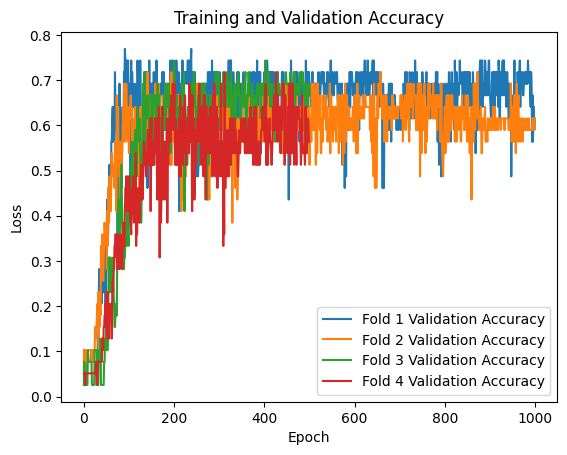

In [77]:
plot_history(history, 'val_accuracy', 'Validation Accuracy', 'Accuracy')

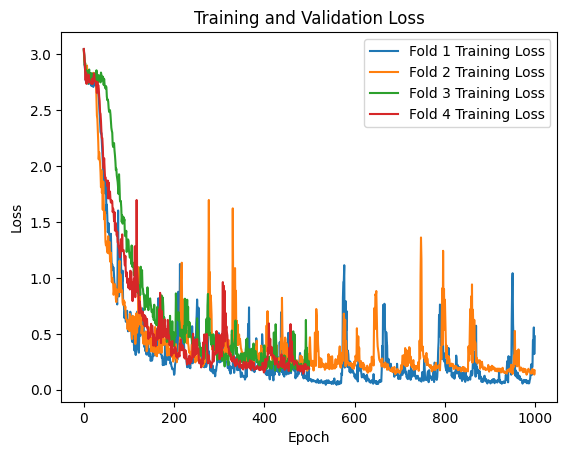

In [78]:
plot_history(history, 'loss', 'Training Loss', 'Loss')

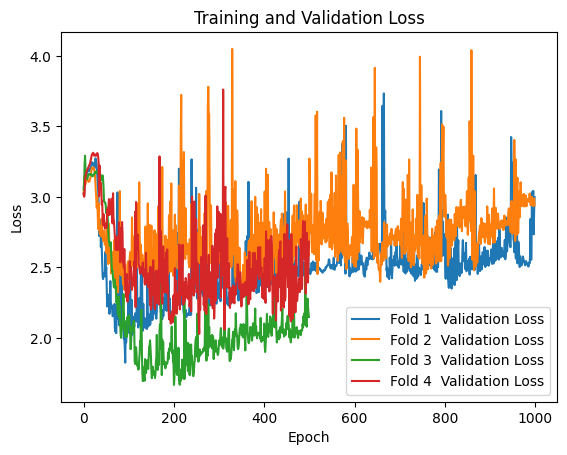

In [79]:
plot_history(history, 'val_loss', ' Validation Loss', 'Loss')

#unbother

In [80]:
model.save('chatbot_nusa_model.h5')

In [81]:
import pickle #save history obj
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

### Running the chatbot and predict the sentences

In [82]:
# load model
model = tf.keras.models.load_model('chatbot_nusa_model.h5')

In [83]:
ERROR_THRESHOLD = 0.25

In [95]:
def bag_of_words(s, data_words, show_details=False):
  bag = [0 for _ in range(len(data_words))]

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts([s])
  word_index = tokenizer.word_index

  words = list(word_index.keys())
  s_words = [Stemmer.stem(word.lower()) for word in words]

  print(s_words)

  for se in s_words:
    for i, w in enumerate(data_words):
        similarity_ratio = fuzz.ratio(w, se)
        if similarity_ratio >= 75:
          bag[i] = 1
          if show_details:
              print("found in bag: %s" % w)

  return np.expand_dims(np.array(bag), axis=0)

In [85]:
def classify(sentence):
  bag = bag_of_words(sentence, df_intents['words'])
  results = model.predict([bag])[0]
  results = [[i,r] for i,r in enumerate(results) if r > ERROR_THRESHOLD]
  results.sort(key=lambda x: x[1], reverse=True)

  return_list = []
  for r in results:
    return_list.append((label[r[0]], r[1]))
  return return_list

In [91]:
def response(sentence):
    results = classify(sentence)
    if results:
      if results[0][1] > 0.5:
        while results:
            for i in data_chat['intents']:
                if i['tag'] == results[0][0]:
                    return random.choice(i['responses'])
            results.pop(0)
      else:
        return "Mohon maaf, Nusa tidak mengerti. Silahkan bertanya pertanyaan yang lain ya! :D"
    else:
        return "Mohon maaf, Nusa tidak mengerti. Silahkan bertanya pertanyaan yang lain ya! :D"

#### Menjalankan Chatbot Nusa

In [92]:
def chat():
	print("Selamat datang di Nusabasa, Siap Belajar, Kan?")
	while True:
		inp = input("Kamu: ")
		if inp.lower()=="keluar":
			break
		print(response(inp))

In [93]:
chat()

Selamat datang di Nusabasa, Siap Belajar, Kan?
Kamu: halo
['halo']
['halo']
1/1 [==============================] - 0s 44ms/step
Hai! Senang bertemu kamu, ada yang bisa Nusa bantu?
Kamu: apa kabar
['apa', 'kabar']
['apa', 'kabar']
1/1 [==============================] - 0s 43ms/step
Dengan Nusabasa, Anda dapat belajar bahasa daerah Indonesia dengan mudah dan menyenangkan.
Kamu: kabar hari ini?
['kabar', 'hari', 'ini']
['kabar', 'hari', 'ini']
1/1 [==============================] - 0s 37ms/step
Hai kamu! Ada yang bisa aku bantu?
Kamu: kabar kamu?
['kabar', 'kamu']
['kabar', 'kamu']
1/1 [==============================] - 0s 43ms/step
Halo, kabar Nusa baik, kamu?
Kamu: keluar
